In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

In [2]:
df = pd.read_csv("E://PHD/Course materials/Sem 1/Data Mining/Assignment/workspace/stock_price_trend_prediction/stock_price_pred_data_mining/Data/05_cluster_output/cluster_output_Kmeans.csv")

In [5]:
# 1. Compute next-week (5 trading days) forward return per stock
df['next_week_close'] = df.groupby('stock_id')['Close'].shift(-5)
df['next_week_return'] = (df['next_week_close'] - df['Close']) / df['Close']
# 2. Binary target: 1 = uptrend, 0 = downtrend or flat
df['target'] = (df['next_week_return'] > 0).astype(int)
# 3. Drop rows where we can't compute future return (last 5 days per stock)
df = df.dropna(subset=['next_week_return'])
# Optional: drop helper column
df = df.drop(columns=['next_week_close'])
drop_cols = ['Date', 'stock_id', 'cluster', 'target', 'next_week_return']
feature_cols = [c for c in df.columns if c not in drop_cols]

print("Number of features:", len(feature_cols))
print("Features:", feature_cols)

Number of features: 23
Features: ['Open', 'High', 'Low', 'Close', 'Volume', 'MA7', 'MA21', 'EMA20', 'EMA50', 'RSI_14', 'MACD', 'MACD_signal', 'MACD_hist', 'BB_upper', 'BB_middle', 'BB_lower', 'CCI_14', 'CMF_20', 'Stoch_K', 'Stoch_D', 'Momentum_10', 'Daily_Return', 'Log_Return']


In [6]:
cluster_models_xgb = {}

for cl in sorted(df['cluster'].unique()):
    print(f"\n🔵 Training Cluster {cl}")

    cluster_df = df[df['cluster'] == cl].copy()
    cluster_df = cluster_df.sort_values('Date')

    if len(cluster_df) < 50:
        print(f"⚠️ Cluster {cl} skipped (too few samples)")
        continue

    # Time-based split (latest 30% for test)
    split_idx = int(len(cluster_df) * 0.7)

    train = cluster_df.iloc[:split_idx]
    test = cluster_df.iloc[split_idx:]

    X_train = train[feature_cols]
    y_train = train['target']

    X_test = test[feature_cols]
    y_test = test['target']

    # ---- XGBoost Classifier ----
    model = XGBClassifier(
        n_estimators=300,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='binary:logistic',
        eval_metric='logloss'
    )

    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    # Evaluation
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    print(f"Cluster {cl} → Accuracy={acc:.4f},  ROC-AUC={auc:.4f}")
    print(classification_report(y_test, y_pred))

    # Store model
    cluster_models_xgb[cl] = model



🔵 Training Cluster 0
Cluster 0 → Accuracy=0.5234,  ROC-AUC=0.5334
              precision    recall  f1-score   support

           0       0.51      0.49      0.50      2272
           1       0.54      0.55      0.54      2411

    accuracy                           0.52      4683
   macro avg       0.52      0.52      0.52      4683
weighted avg       0.52      0.52      0.52      4683


🔵 Training Cluster 1
Cluster 1 → Accuracy=0.5052,  ROC-AUC=0.5047
              precision    recall  f1-score   support

           0       0.49      0.29      0.37      8402
           1       0.51      0.71      0.59      8680

    accuracy                           0.51     17082
   macro avg       0.50      0.50      0.48     17082
weighted avg       0.50      0.51      0.48     17082



ROC–AUC Score: 0.5046533385182593


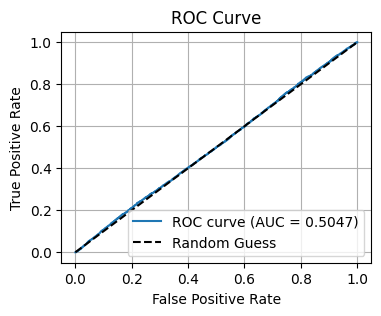

In [8]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Predict probabilities for the positive class (1 = uptrend)
y_prob = model.predict_proba(X_test)[:, 1]

# Calculate ROC–AUC
roc_auc = roc_auc_score(y_test, y_prob)
print("ROC–AUC Score:", roc_auc)

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Plot ROC Curve
plt.figure(figsize=(4, 3))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()
